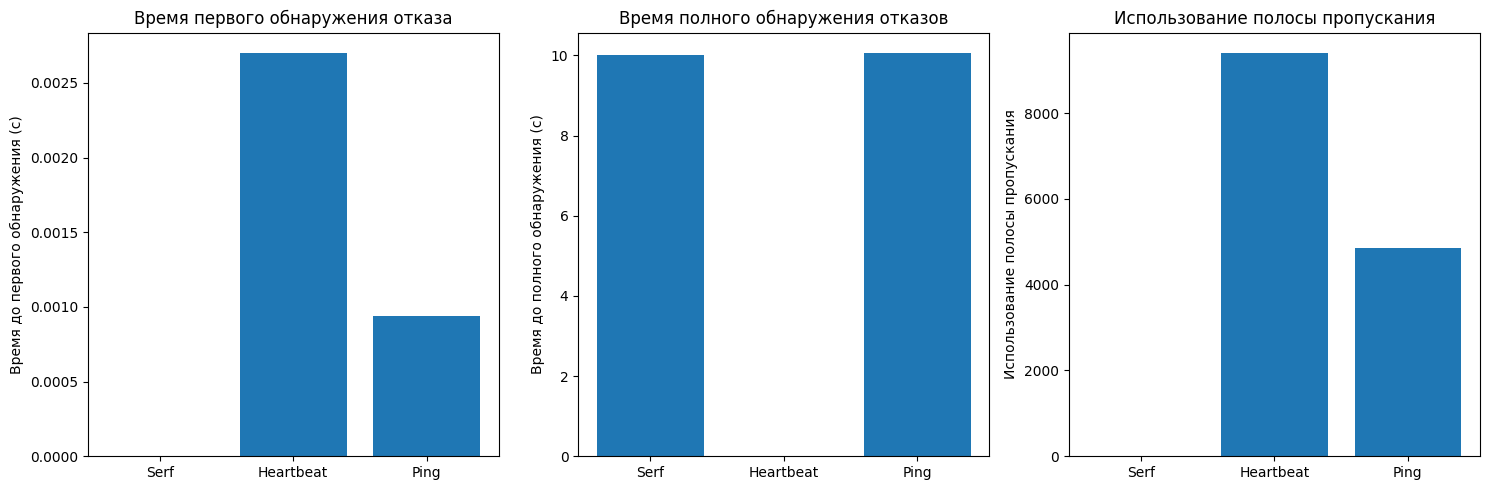

Результаты симуляции:

Serf:
Время до 'Хотя бы один узел знает': 0.00 с
Время до 'Все живые узлы знают': 10.02 с
Использование полосы пропускания: 0 (условных единиц)

Heartbeat:
Время до 'Хотя бы один узел знает': 0.00 с
Время до 'Все живые узлы знают': 0.00 с
Использование полосы пропускания: 9405 (условных единиц)

Ping:
Время до 'Хотя бы один узел знает': 0.00 с
Время до 'Все живые узлы знают': 10.06 с
Использование полосы пропускания: 4845 (условных единиц)


In [7]:
import random
import time
import matplotlib.pyplot as plt

class Node:
    def __init__(self, node_id):
        self.id = node_id
        self.knows_failure = False

class BaseSimulator:
    def __init__(self, num_nodes, interval, node_failures):
        self.nodes = [Node(i) for i in range(num_nodes)]
        self.interval = interval
        self.node_failures = node_failures
        self.failed_nodes = set()
        self.bandwidth_usage = 0

    def simulate_failure(self):
        num_failures = int(len(self.nodes) * self.node_failures / 100)
        self.failed_nodes = set(random.sample(range(len(self.nodes)), num_failures))
        if self.failed_nodes:
            self.nodes[random.choice(list(self.failed_nodes))].knows_failure = True
        elif self.nodes:
            self.nodes[0].knows_failure = True

    def run_simulation(self):
        self.simulate_failure()
        start_time = time.time()
        first_knowledge_time = None
        all_knowledge_time = None

        while True:
            self.detect_failures()
            current_time = time.time() - start_time

            if first_knowledge_time is None and any(node.knows_failure for node in self.nodes if node.id not in self.failed_nodes):
                first_knowledge_time = current_time

            if all(node.knows_failure for node in self.nodes if node.id not in self.failed_nodes):
                all_knowledge_time = current_time
                break

            if current_time > 10:  # Ограничение времени симуляции
                break

            time.sleep(self.interval)

        return first_knowledge_time or 0, all_knowledge_time or current_time, self.bandwidth_usage

class SerfSimulator(BaseSimulator):
    def __init__(self, num_nodes, gossip_interval, gossip_fanout, packet_loss, node_failures):
        super().__init__(num_nodes, gossip_interval, node_failures)
        self.gossip_fanout = gossip_fanout
        self.packet_loss = packet_loss

    def detect_failures(self):
        for node in self.nodes:
            if node.id not in self.failed_nodes and node.knows_failure:
                active_nodes = [n for n in range(len(self.nodes)) if n != node.id and n not in self.failed_nodes]
                targets = random.sample(active_nodes, min(self.gossip_fanout, len(active_nodes))) if active_nodes else []
                for target in targets:
                    if random.random() > self.packet_loss / 100:
                        self.nodes[target].knows_failure = True
                        self.bandwidth_usage += 1

class HeartbeatSimulator(BaseSimulator):
    def detect_failures(self):
        for node in self.nodes:
            if node.id not in self.failed_nodes:
                for other_node in self.nodes:
                    if other_node.id != node.id:
                        if other_node.id in self.failed_nodes:
                            node.knows_failure = True
                        self.bandwidth_usage += 1

class PingSimulator(BaseSimulator):
    def detect_failures(self):
        for node in self.nodes:
            if node.id not in self.failed_nodes:
                target = random.choice([n for n in range(len(self.nodes)) if n != node.id])
                if target in self.failed_nodes:
                    node.knows_failure = True
                self.bandwidth_usage += 1

def run_comparison(num_nodes, node_failures):
    serf_sim = SerfSimulator(num_nodes, 0.2, 3, 0, node_failures)
    heartbeat_sim = HeartbeatSimulator(num_nodes, 0.2, node_failures)
    ping_sim = PingSimulator(num_nodes, 0.2, node_failures)

    serf_result = serf_sim.run_simulation()
    heartbeat_result = heartbeat_sim.run_simulation()
    ping_result = ping_sim.run_simulation()

    return serf_result, heartbeat_result, ping_result

def plot_comparison(results):
    protocols = ['Serf', 'Heartbeat', 'Ping']
    first_times = [r[0] for r in results]
    all_times = [r[1] for r in results]
    bandwidths = [r[2] for r in results]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.bar(protocols, first_times)
    ax1.set_ylabel('Время до первого обнаружения (с)')
    ax1.set_title('Время первого обнаружения отказа')

    ax2.bar(protocols, all_times)
    ax2.set_ylabel('Время до полного обнаружения (с)')
    ax2.set_title('Время полного обнаружения отказов')

    ax3.bar(protocols, bandwidths)
    ax3.set_ylabel('Использование полосы пропускания')
    ax3.set_title('Использование полосы пропускания')

    plt.tight_layout()
    plt.show()

# Запуск сравнения
num_nodes = 100
node_failures = 5  # 5% узлов отказывают

results = run_comparison(num_nodes, node_failures)
plot_comparison(results)

print("Результаты симуляции:")
for protocol, result in zip(['Serf', 'Heartbeat', 'Ping'], results):
    print(f"\n{protocol}:")
    print(f"Время до 'Хотя бы один узел знает': {result[0]:.2f} с")
    print(f"Время до 'Все живые узлы знают': {result[1]:.2f} с")
    print(f"Использование полосы пропускания: {result[2]} (условных единиц)")